In [1]:
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern

import advopt
from advopt import *

SEED = 999111

ROOT = os.path.dirname(os.path.dirname(advopt.__file__))
DATA_ROOT = os.path.join(ROOT, 'results')
FIG_ROOT = os.path.join(ROOT, 'figures')
LOG_ROOT = os.path.join(ROOT, 'logs')

os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(FIG_ROOT, exist_ok=True)
os.makedirs(LOG_ROOT, exist_ok=True)

/mnt/mborisyak/.pyenv/versions/3.7.6/envs/py3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/mnt/mborisyak/.pyenv/versions/3.7.6/envs/py3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
task = tasks.PythiaTuneMC(n_params=1, n_jobs=1)

repeat = 100
budget = 32 * 1024

In [3]:
### the results of the experiment are cached
### in order to recompute, please, delete the content of DATA_ROOT
results = experiment(
    root=DATA_ROOT,
    task=task,
    models=['JSD-cat', 'log-pJSD-cat', 'lin-pJSD-cat'],
    optimizer=bayesian_optimization(
        base_estimator=GaussianProcessRegressor(
            kernel=Matern(length_scale=1, length_scale_bounds=(1e-3, 1e+3)),
            alpha=1e-4
        ),
        n_initial_points=5,
        metric=adjusted(verbose=True)
    ),
    budget=budget,
    repeat=repeat,
    progress=tqdm,
    devices=['cpu'] * 10,
    seed=SEED,
    logs=LOG_ROOT,
)

In [4]:
### change of order
results = {
    'JSD-cat' : results['JSD-cat'],
    'lin-pJSD-cat' : results['lin-pJSD-cat'],
    'log-pJSD-cat' : results['log-pJSD-cat'],
}

properties = {
    'JSD-cat' : dict(color='black', label='JSD'),
    'lin-pJSD-cat' : dict(color=plt.cm.tab10(0), label='linear AD'),
    'log-pJSD-cat' : dict(color=plt.cm.tab10(1), label='logarithmic AD')
}

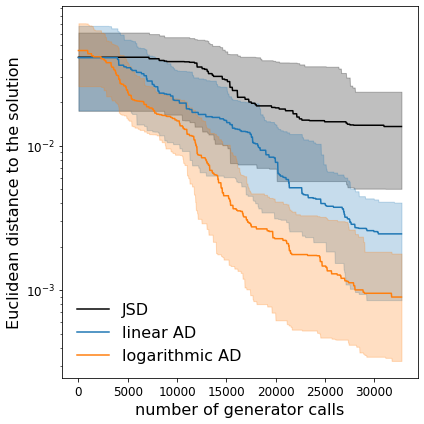

In [5]:
plt.figure(figsize=(6, 6))
plot_convergence(
    results, distance_to(task.solution()),
    qs=(0.25,), budget=budget,
    properties=properties,
    individual=False, mode=None,
)

plt.xlabel('number of generator calls', fontsize=16)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Euclidean distance to the solution', fontsize=16)
plt.yticks(fontsize=12)

plt.legend(loc='lower left', fontsize=16, frameon=False)

plt.tight_layout()
plt.savefig(os.path.join(FIG_ROOT, 'Figure-3a.pdf'))

In [6]:
costs = {
    k : np.log2(
        np.concatenate([
            res.costs
            for res in results[k]
        ], axis=0)
    )
    for k in results
}

all_costs = np.concatenate([costs[k] for k in costs], axis=0)

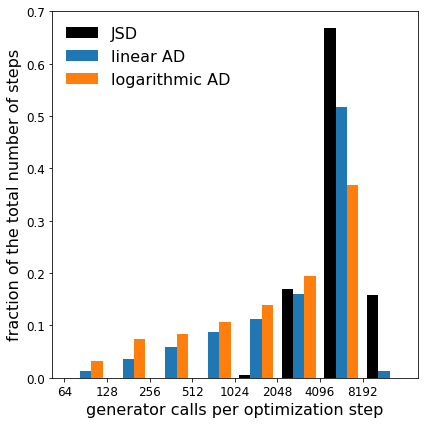

In [7]:
plt.figure(figsize=(6, 6))
a, b = int(np.floor(np.min(all_costs))), int(np.ceil(np.max(all_costs)))

plt.hist(
    list(costs.values()),
    label=[properties[k]['label'] for k in costs],
    color=[properties[k]['color'] for k in costs],
    histtype='bar', bins=b - a, range=(a, b), log=False,
    lw=2, density=True
)

plt.xticks(ticks=range(a, b), labels=['%d' % (2 ** i) for i in range(a, b)], fontsize=12)
plt.xlabel('generator calls per optimization step', fontsize=16)

plt.yticks(fontsize=12)
plt.ylim([0, 0.7])
plt.ylabel('fraction of the total number of steps', fontsize=16)

plt.legend(loc='upper left', fontsize=16, frameon=False)

plt.tight_layout()
plt.savefig(os.path.join(FIG_ROOT, 'Figure-3b.pdf'))

In [8]:
step_results = {
    k : [
        OptimizationResults(points=r.points, values=r.values, costs=np.ones_like(r.costs), seed=r.seed)
        for r in results[k]
    ]
    for k in results
}

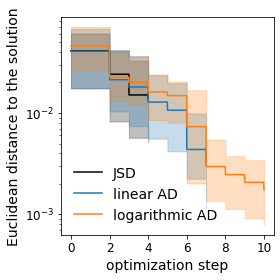

In [9]:
plt.figure(figsize=(4, 4))
plot_convergence(
    step_results, distance_to(task.solution()), qs=(0.25, ),
    properties=properties,
    individual=False, extrapolate=False
)

plt.xlabel('optimization step', fontsize=14)
plt.xticks(fontsize=12)

plt.ylabel('Euclidean distance to the solution', fontsize=14)
plt.yticks(fontsize=12)
plt.yscale('log')

plt.legend(loc='lower left', fontsize=14, frameon=False)

plt.tight_layout()
plt.savefig(os.path.join(FIG_ROOT, 'Figure-6b.pdf'))